# 03_baseline_models



In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  RobustScaler, LabelEncoder

import statsmodels.formula.api as sm

# import custom .py functions from src/ directory 
sys.path.append('..')
from src.datagen import print_interval_dict
from src.scale import scale_features, sigmoid, log_plus_one, encode_categories
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred, plot_bdgt_sched_scaled, \
                          plot_change_trend


# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [2]:
file_path = '../data/interim/NYC_capital_projects_3yr.csv'
    
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [3]:
data = pd.read_csv(file_path)
data_full = pd.read_csv('../data/interim/Capital_Projects_clean.csv') 

In [4]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 149
Number of unique projects in dataset: 149


In [5]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])

In [6]:
data.info()

data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,Current_Project_Year,...,Schedule_Change,Budget_Change,Schedule_Change_Ratio,Budget_Change_Ratio,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Duration_End_Ratio,Budget_End_Ratio,Duration_Ratio_Inv,Budget_Ratio_Inv
0,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,5.94,6,...,91,"-15,619,967.29",0.04,-0.08,0.09,0.08,1.04,0.92,-0.04,0.09
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,2-Design,6.34,7,...,334,"9,618,785.30",0.19,0.18,0.15,0.18,1.19,1.18,-0.16,-0.15
2,91,Mill Basin Bridge Replacement,Complete replacement of bascule bridge with a ...,Bridges,Brooklyn,DOT,not_specified,2-Design,7.44,8,...,247,"-34,672,662.00",0.09,-0.09,0.10,0.09,1.09,0.91,-0.08,0.10


## Inspect projects by category

Can any categories be combined to better balance and reduce the number of categories for one-hot-encoding in the baseline model. 

In [7]:
print(
    'The original {} project categories and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Category'].nunique(),
        data['Category'].value_counts()
    )
)

rename_cat_dict = {
    'Bridges, Streets and Roadways': 'Bridges',
    'Parks, Streets and Roadways': 'Parks',
    'Industrial Development, Parks': 'Industrial Development',
    'Other Government Facilities': 'Other Govt Facilities and Improvements',
    'Public Safety and Criminal Justice': 'Other Govt Facilities and Improvements',
    'Arts and Culture': 'Other Govt Facilities and Improvements',
    'Health and Hospitals': 'Other Govt Facilities and Improvements',
}

data['Category'] = data['Category'].copy().map(rename_cat_dict).fillna(data['Category'])

print(
    'The newly mapped {} project categories and project counts:\n\n'\
    '{}\n'.format(
        data['Category'].nunique(),
        data['Category'].value_counts()
    )
)

The original 17 project categories and assocated project counts:

Streets and Roadways                  31
Sewers                                20
Schools                               15
Industrial Development                15
Water Supply                          13
Wastewater Treatment                  13
Bridges, Streets and Roadways          9
Bridges                                7
Sanitation                             6
Public Safety and Criminal Justice     4
Other Government Facilities            4
Ferries                                3
Health and Hospitals                   3
Arts and Culture                       2
Parks                                  2
Parks, Streets and Roadways            1
Industrial Development, Parks          1
Name: Category, dtype: int64


The newly mapped 11 project categories and project counts:

Streets and Roadways                      31
Sewers                                    20
Bridges                                   16
Industrial 

In [8]:
print(
    'The original {} managing agencies and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Managing_Agency'].nunique(),
        data['Managing_Agency'].value_counts()
    )
)

The original 7 managing agencies and assocated project counts:

DDC     63
DOT     34
DEP     19
SCA     15
EDC     14
DSNY     2
DCAS     2
Name: Managing_Agency, dtype: int64




In [9]:
print(
    'The original {} client agencies and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Client_Agency'].nunique(),
        data['Client_Agency'].value_counts()
    )
)

The original 19 client agencies and assocated project counts:

DEP                    53
not_specified          35
DOT                    17
DOE                    15
DSNY                    7
DCAS                    4
H+H                     3
DPR                     3
DCLA                    2
DOT, Mayor's Office     1
NYPD                    1
DEP, EDC                1
BWS                     1
Mayor's Office          1
DOHMH, HHC              1
ORR                     1
EDC                     1
DSBS                    1
DHS                     1
Name: Client_Agency, dtype: int64




In [10]:
print(
    'The original {} borough values and assocated project counts:\n\n'\
    '{}\n\n'.format(
        data['Borough'].nunique(),
        data['Borough'].value_counts()
    )
)

The original 15 borough values and assocated project counts:

not_specified                      47
Brooklyn                           30
Queens                             19
Manhattan                          17
Bronx                              12
Staten Island                       9
Citywide                            5
New York                            2
Valhalla                            2
Olive                               1
Manhattan, Staten Island, Bronx     1
Manhattan, Bronx                    1
Marlboro                            1
Brooklyn, Queens                    1
Port Jervis                         1
Name: Borough, dtype: int64




## Subset and scale data for X and y frames

In [11]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
    'Category'
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]


In [12]:
X, y = data[X_cols], data[y_cols]

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Budget_Start    149 non-null    float64
 1   Duration_Start  149 non-null    int64  
 2   Category        149 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ KB


In [14]:
# One hot encode categorical variables
drop_cat = 'Other Govt Facilities and Improvements'
one_hot = True

X = encode_categories(
    X, colname='Category',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True
)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Budget_Start            149 non-null    float64
 1   Duration_Start          149 non-null    int64  
 2   Bridges                 149 non-null    uint8  
 3   Ferries                 149 non-null    uint8  
 4   Industrial_Development  149 non-null    uint8  
 5   Parks                   149 non-null    uint8  
 6   Sanitation              149 non-null    uint8  
 7   Schools                 149 non-null    uint8  
 8   Sewers                  149 non-null    uint8  
 9   Streets_and_Roadways    149 non-null    uint8  
 10  Wastewater_Treatment    149 non-null    uint8  
 11  Water_Supply            149 non-null    uint8  
dtypes: float64(1), int64(1), uint8(10)
memory usage: 3.9 KB


In [15]:
random_state = 109
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

In [16]:
print('{}\t{}'.format(X_train.shape, y_train.shape))
print('{}\t{}'.format(X_test.shape, y_test.shape))

(134, 12)	(134, 2)
(15, 12)	(15, 2)


In [17]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify binary variable columns to exclude from scaling
exclude_scale_cols = list(X)[2:]

# # Reset y dataframe indices or else we will run into indexing issues
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)


# Standardize both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_train_std, Scaler_std = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Perform 'Robust to outliers' standardization on both X_train and X_test
scaler = RobustScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_train_rstd, Scaler_rstd = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_rstd, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

# Standardize X_train and X_test, pass through sigmoid transformation
# and re-standardize to minimize skew of data
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid
reapply_scaler = True


X_train_std_sig, Scaler_std_sig = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

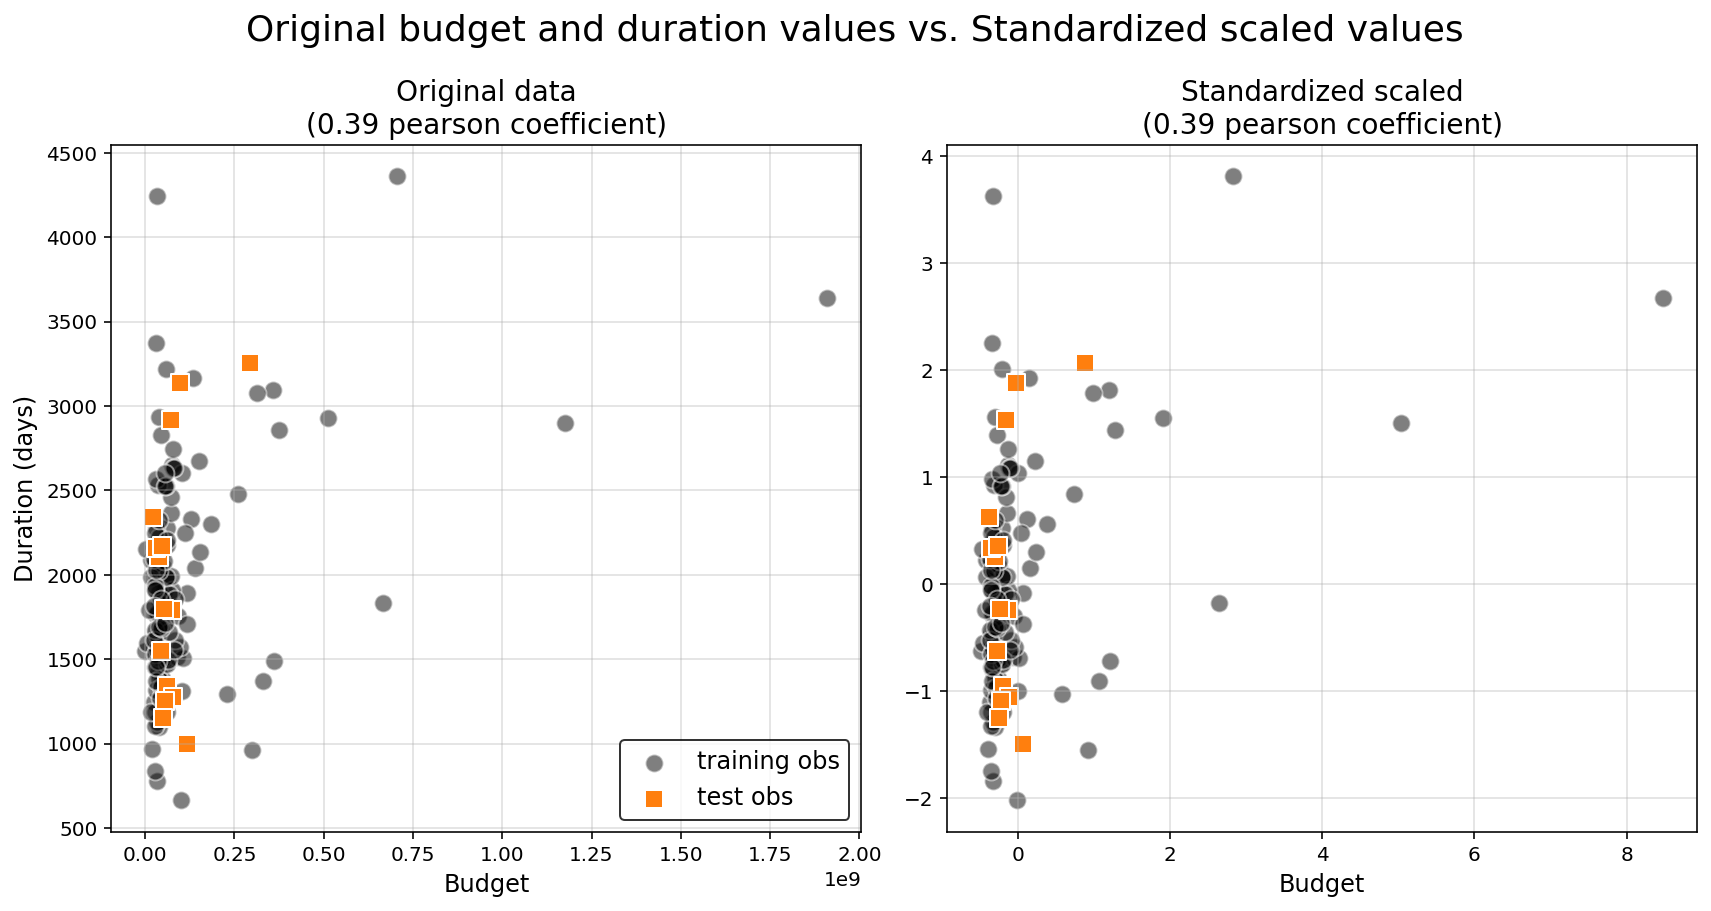

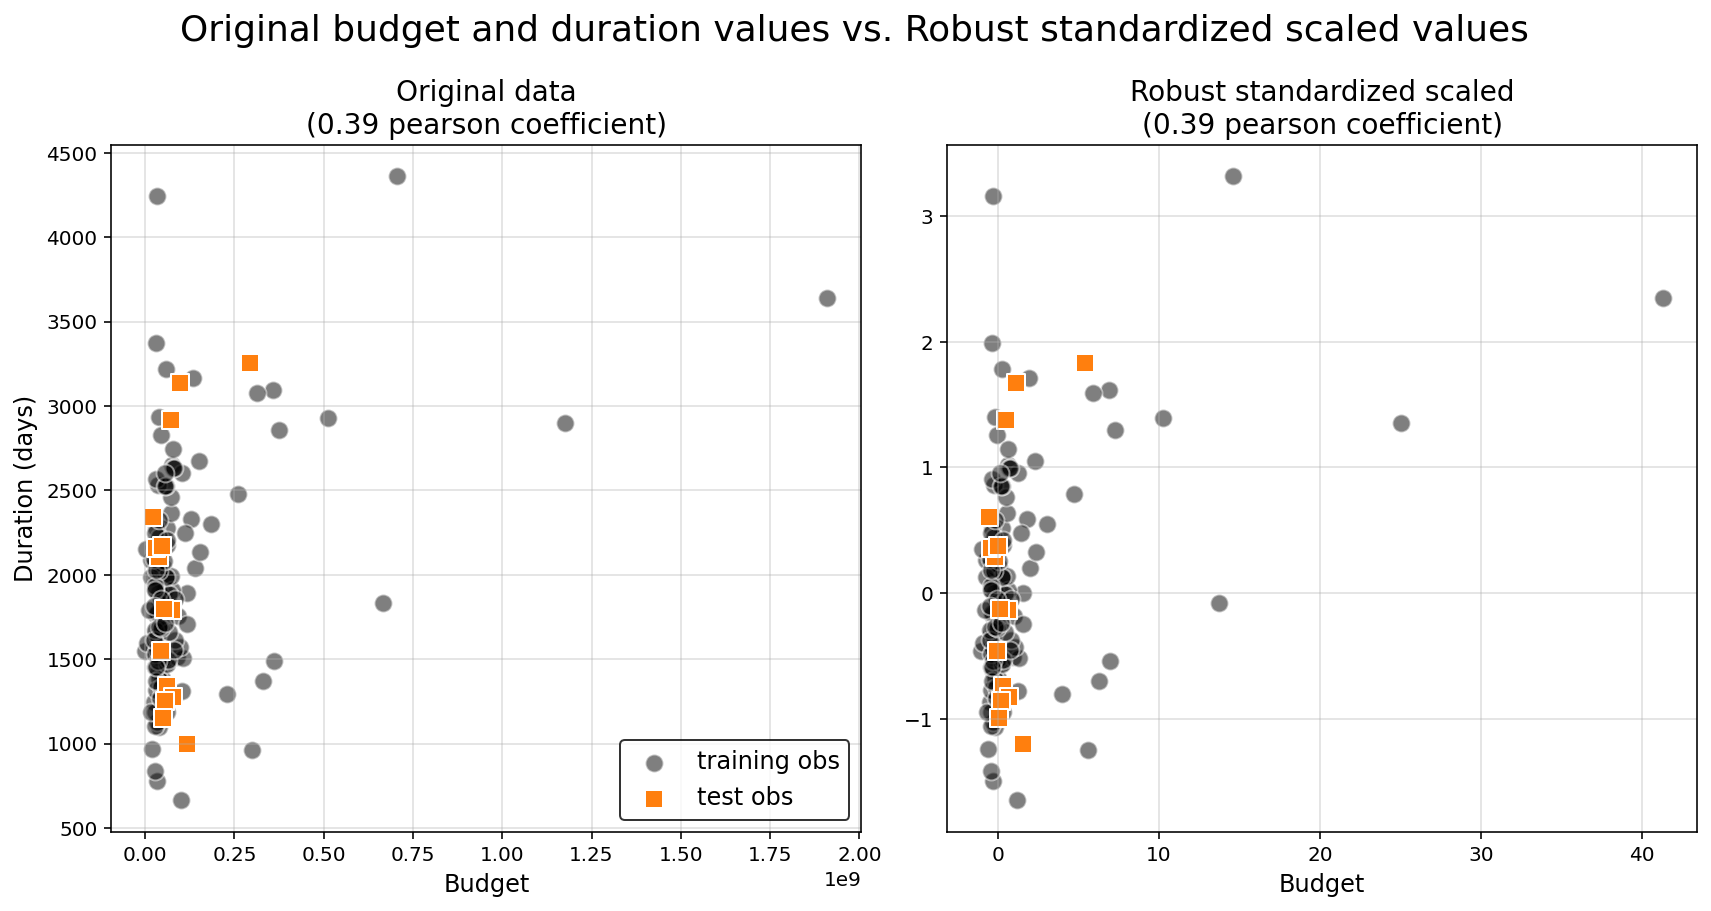

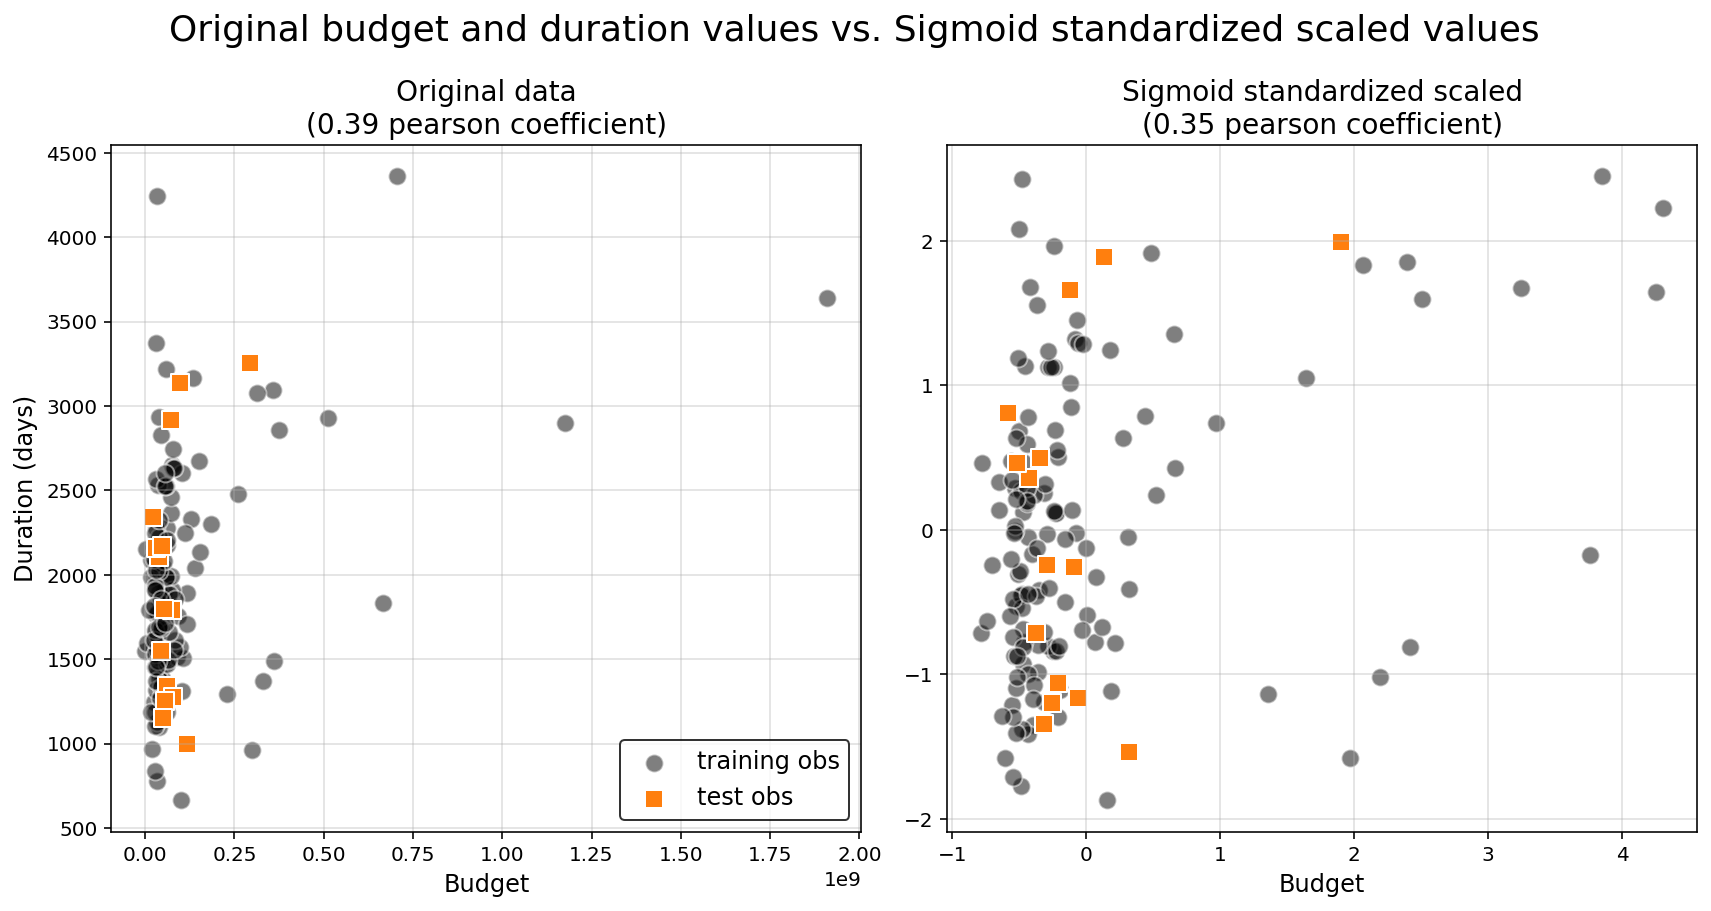

In [18]:
# inspect scaled datasets
plot_bdgt_sched_scaled(X_train, X_train_std, 'Standardized', X_test, X_test_std)
plot_bdgt_sched_scaled(X_train, X_train_rstd, 'Robust standardized', X_test, X_test_rstd)
plot_bdgt_sched_scaled(X_train, X_train_std_sig, 'Sigmoid standardized', X_test, X_test_std_sig)

## Define functions for fitting and evaluating models

In [19]:
# import statsmodels.formula.api as sm

# sm_formulas = [
#     'Budget_Start + Duration_Start + Budget_Start * Duration_Start',
#     'Budget_Start + Duration_Start'
# ]

# model_descr = 'Linear regression with budget change ratio interaction'

# model_LR_norm_log = generate_model_dict(
#     sm.ols,
#     model_descr,
#     X_train, X_test, y_train, y_test,
#     multioutput=True,
#     verbose=False,
#     predictions=True,
#     scores=True,
#     model_api='statsmodels',
#     sm_formulas=sm_formulas
# )

# print_model_results(model_LR_norm_log)

In [21]:
features = [
    'Budget_Start',
    'Duration_Start'
]

model_descr = 'Linear regression unscaled data, baseline'

model_LR = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train[features], X_test[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR)


model_descr = 'Linear regression scaled data, baseline'

model_LR_scaled = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train_std[features], X_test_std[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR_scaled)

model_descr = 'Linear regression robust scaled data, baseline'

model_LR_rscaled = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train_rstd[features], X_test_rstd[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR_rscaled)

model_descr = 'Linear regression sigmoid scaled data, baseline'

model_LR_sigscaled = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR_sigscaled)


MODEL SUMMARY:
Linear regression unscaled data, baseline


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0046
		Test		-0.4248

	Schedule_Change_Ratio

		Training	0.2260
		Test		0.2391




MODEL SUMMARY:
Linear regression scaled data, baseline


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0046
		Test		-0.4248

	Schedule_Change_Ratio

		Training	0.2260
		Test		0.2391




MODEL SUMMARY:
Linear regression robust scaled data, baseline


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0046
		Test		-0.4248

	Schedule_Change_Ratio

In [22]:
features = list(X_train)

model_descr = 'Linear regression unscaled data'

model_LR = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train[features], X_test[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR)


model_descr = 'Linear regression scaled data'

model_LR_scaled = generate_model_dict(
    LinearRegression,
    model_descr,
    X_train_std[features], X_test_std[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn'
)

print_model_results(model_LR_scaled)


MODEL SUMMARY:
Linear regression unscaled data


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0611
		Test		-2.5771

	Schedule_Change_Ratio

		Training	0.4262
		Test		0.2957




MODEL SUMMARY:
Linear regression scaled data


The fitted model object(s):

	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0611
		Test		-2.5771

	Schedule_Change_Ratio

		Training	0.4262
		Test		0.2957





In [23]:
' + '.join([feat.replace(' ', '_')for feat in features])

'Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply'

In [24]:
features = list(X_train)

model_descr = 'Linear regression sigmoid scaled data'

sm_formulas = [
    ' + '.join(features),
    ' + '.join(features)
]

model_LR_scaled = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)

print_model_results(model_LR_scaled)


MODEL SUMMARY:
Linear regression sigmoid scaled data


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0686
		Test		-2.5340

	Schedule_Change_Ratio

		Training	0.4523
		Test		0.3364





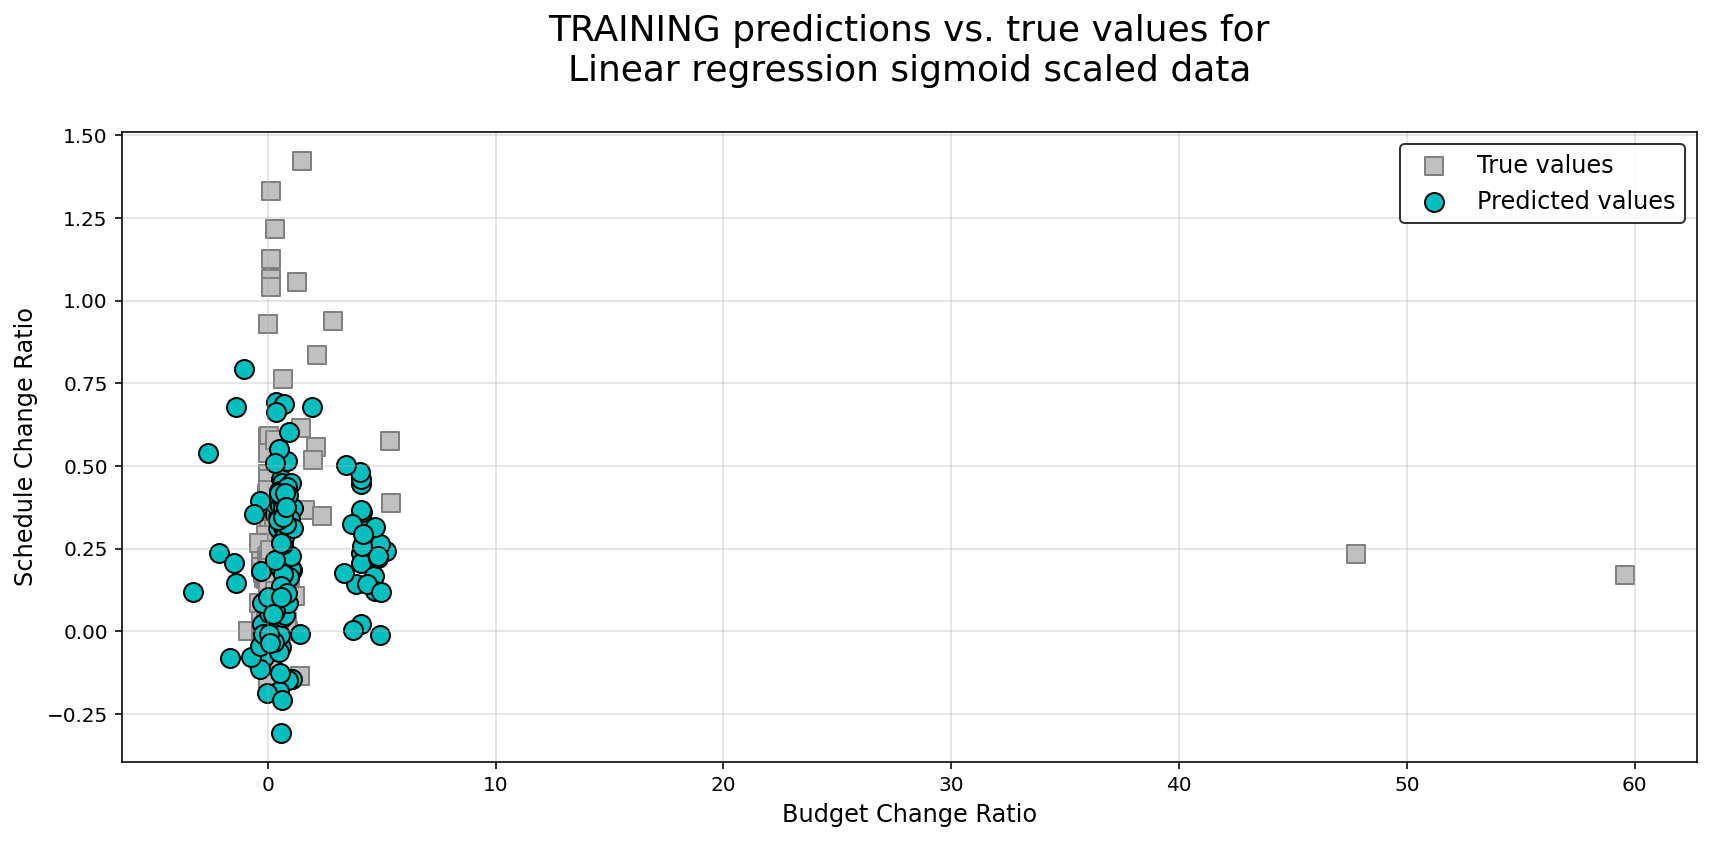

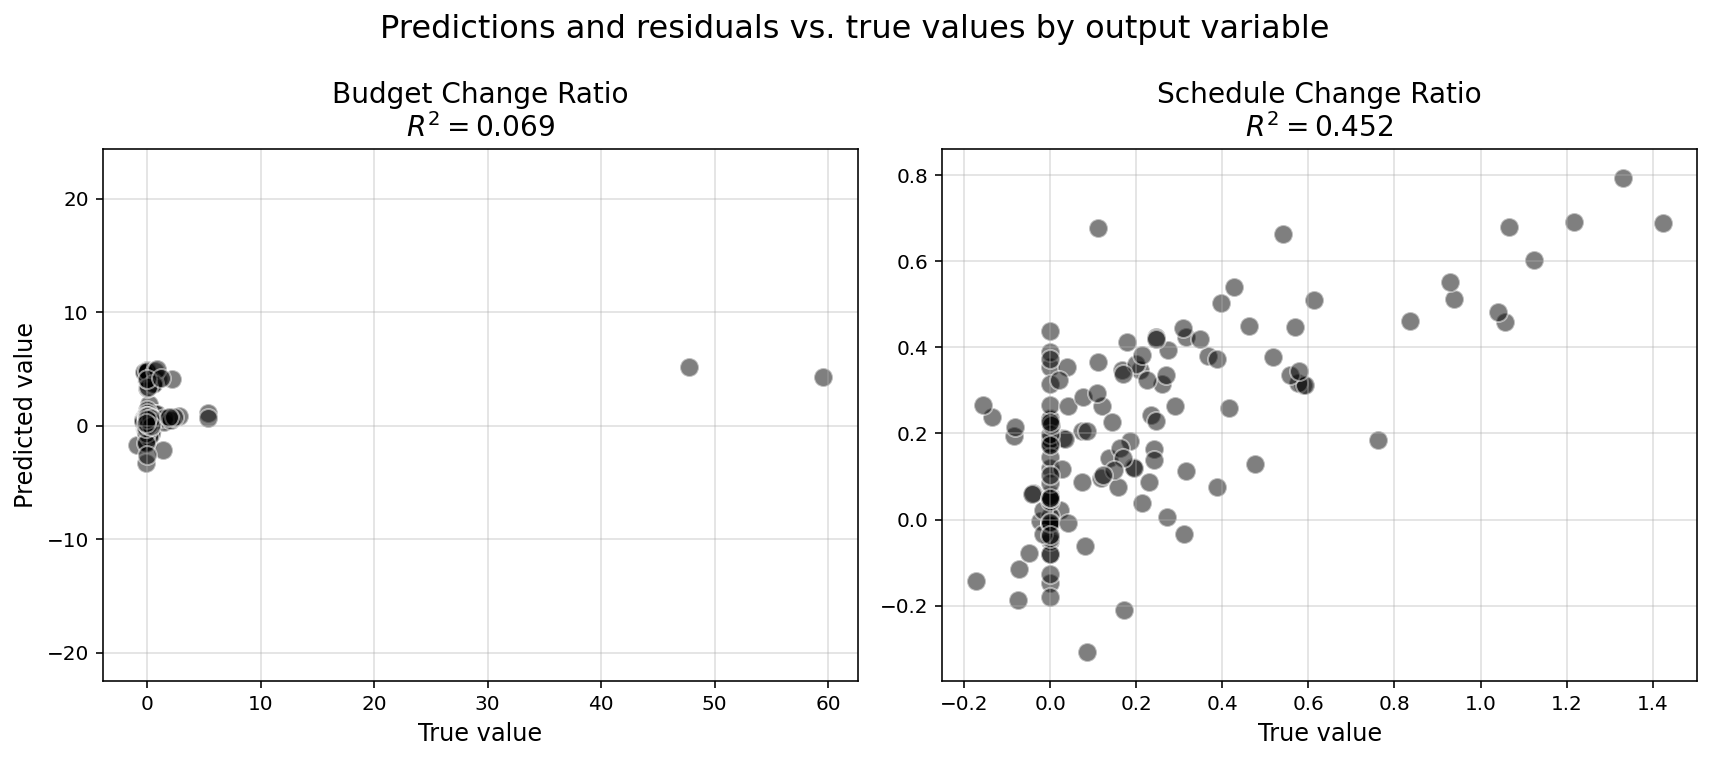

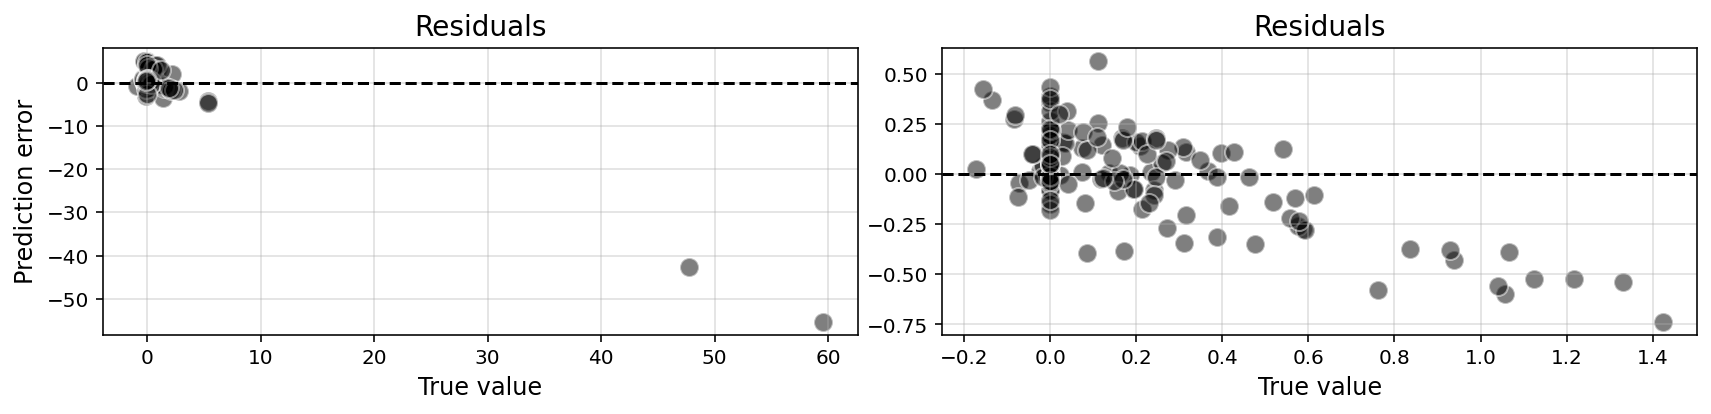

In [25]:
model_descr = 'linear regression with normalized log+1 data linear regression with normalized'
plot_true_pred(model_dict=model_LR_scaled, dataset='train')

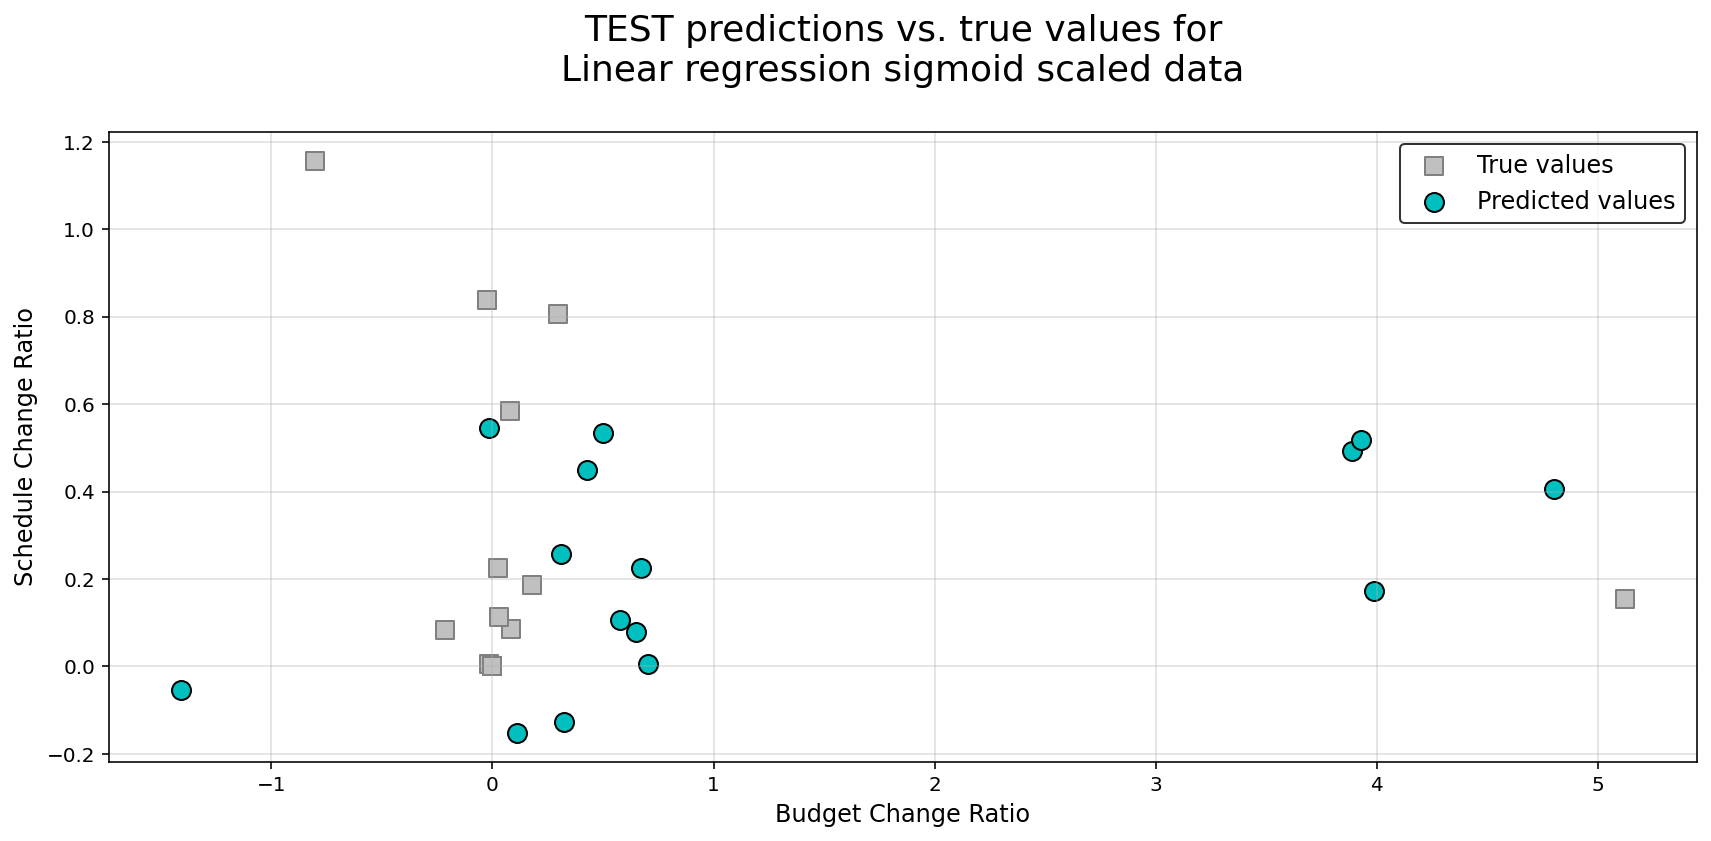

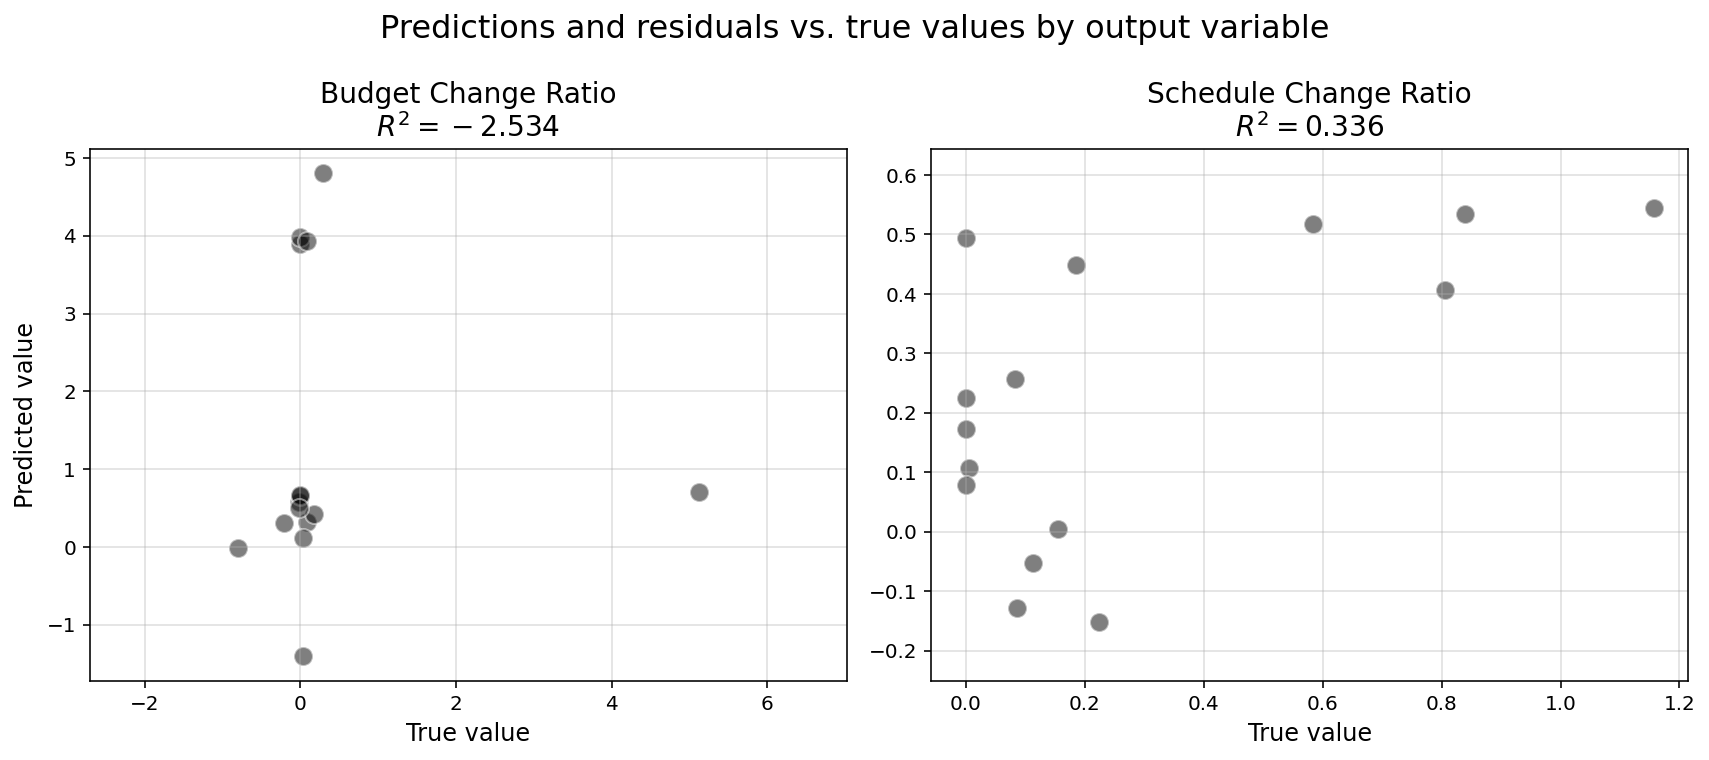

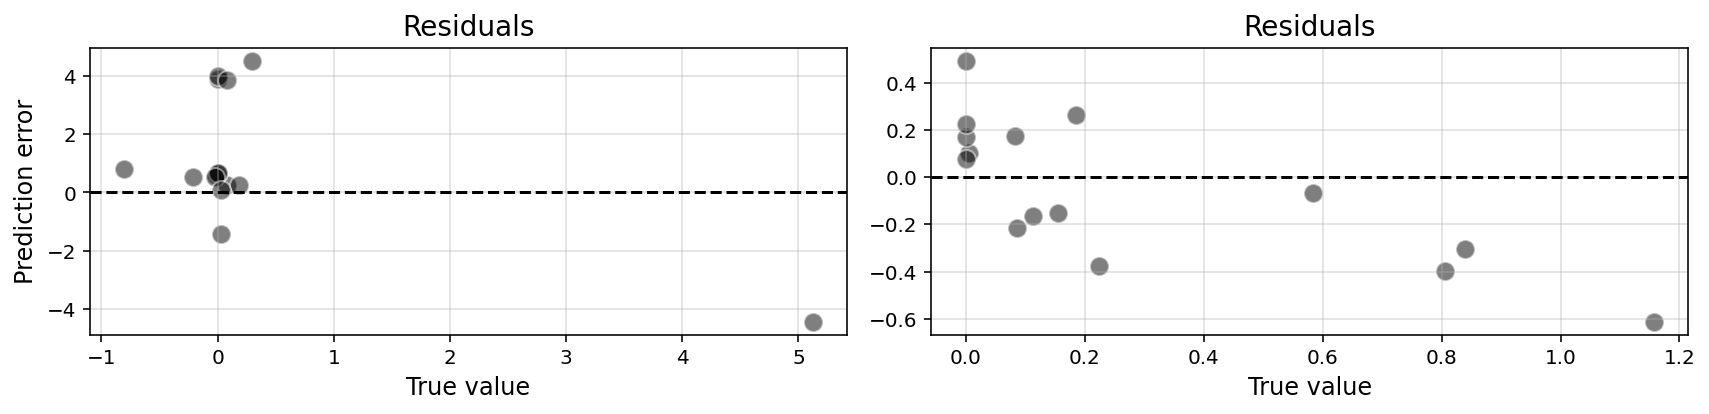

In [27]:
model_descr = 'linear regression with normalized log+1 data linear regression with normalized'
plot_true_pred(model_dict=model_LR_scaled, dataset='test')

In [34]:
model_LR['model'][0].coef_

array([[-2.22301204e-09, -2.36475218e-04, -6.87693432e-02,
        -4.91633376e-02,  1.45986354e-01, -6.64427105e-01,
        -9.75724328e-02, -5.89492414e-01,  3.39127712e+00,
         8.08855591e-02, -2.17387640e-01,  3.99977757e+00],
       [ 3.81087661e-10, -3.01031860e-04,  1.21945455e-01,
        -2.12009196e-01,  9.29481143e-02, -5.02449897e-02,
        -3.86797752e-02, -3.26495502e-01,  9.17228248e-02,
         1.14762938e-03,  2.22901921e-01, -1.26592571e-02]])

In [29]:
from pygam import LinearGAM, s, f



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

In [30]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Record_ID                2095 non-null   object 
 1   Date_Reported_As_Of      2095 non-null   object 
 2   PID                      2095 non-null   int64  
 3   Project_Name             2095 non-null   object 
 4   Description              2095 non-null   object 
 5   Category                 2095 non-null   object 
 6   Borough                  2095 non-null   object 
 7   Managing_Agency          2095 non-null   object 
 8   Client_Agency            2095 non-null   object 
 9   Current_Phase            2095 non-null   object 
 10  Design_Start             2095 non-null   object 
 11  Original_Budget          2095 non-null   float64
 12  Budget_Forecast          2095 non-null   float64
 13  Latest_Budget_Changes    2095 non-null   float64
 14  Total_Budget_Changes    

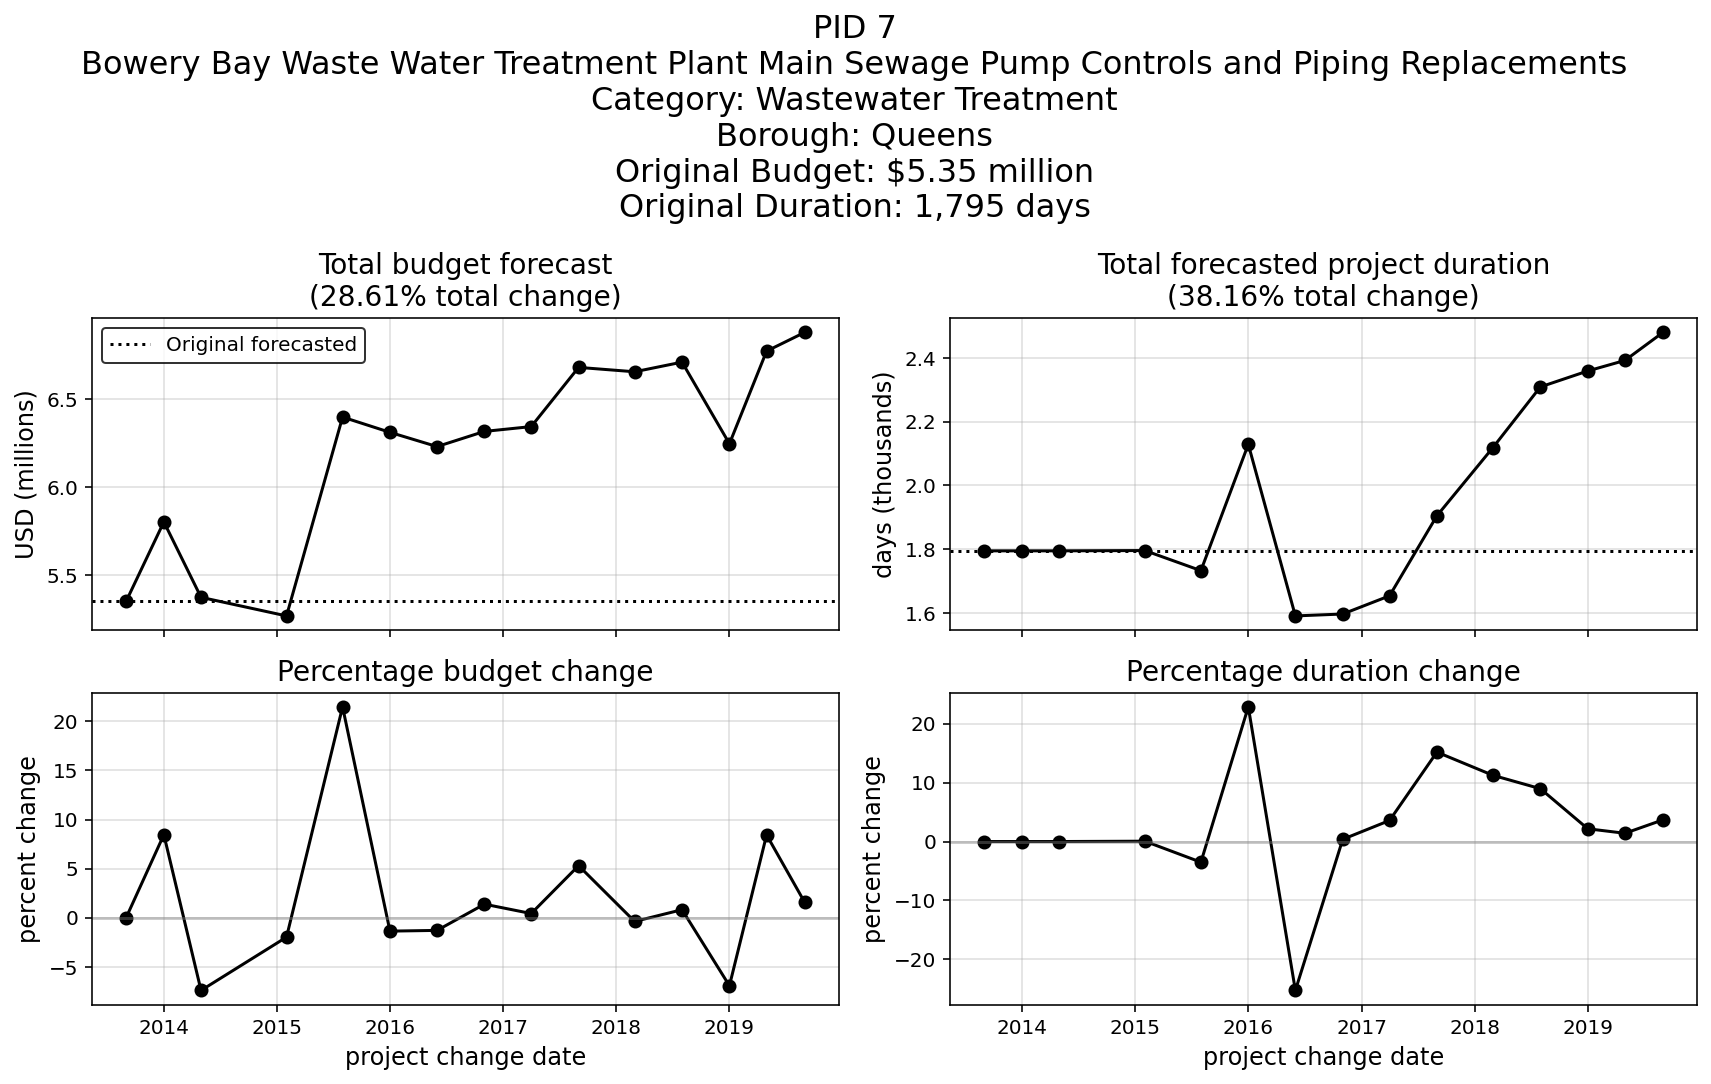

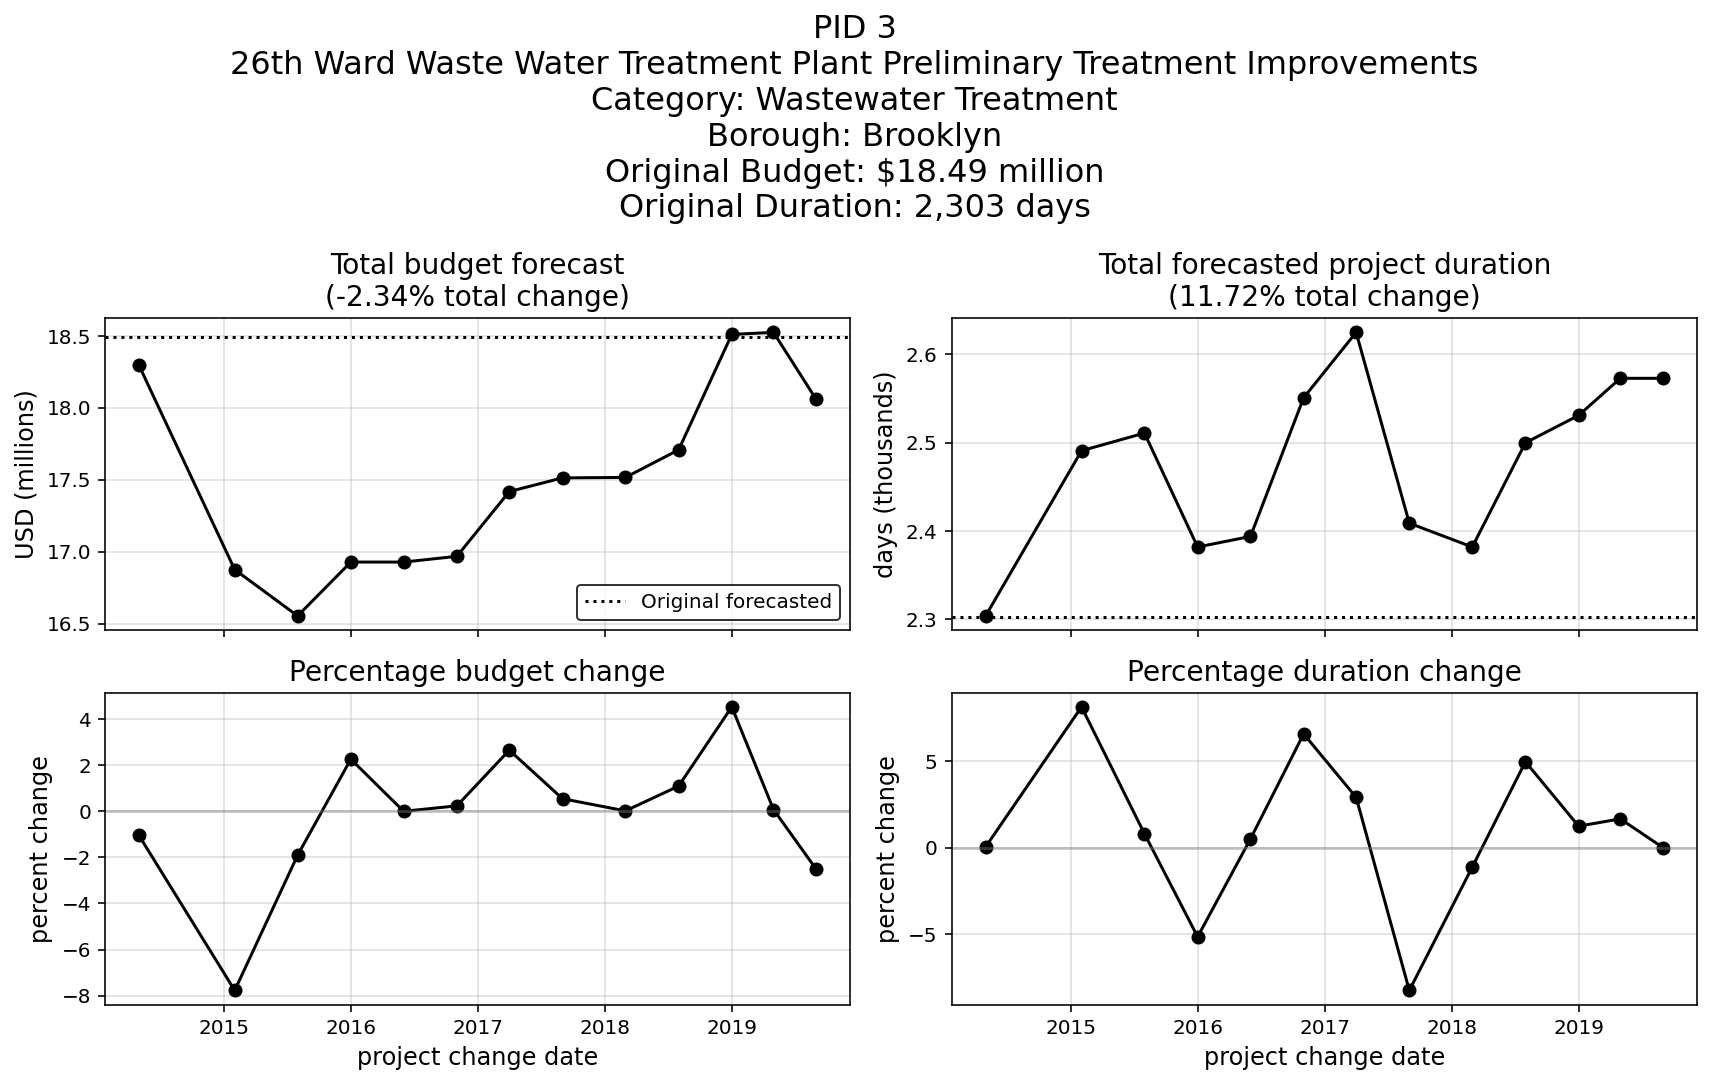

In [7]:
plot_change_trend(trend_data=data_full, pid_data=data_interval, pid=7, interval=None)
plot_change_trend(data_full, data, 3, None)

In [116]:
80000*4777

382160000

In [26]:
model_LR_norm_log.keys()

dict_keys(['description', 'model', 'y_variables', 'formulas', 'y_values', 'predictions', 'score'])

In [11]:
sys.path.append('..')
from src.datagen import generate_interval_data

# set interval
predict_interval = 2

df_interval = generate_interval_data(data_clean, predict_interval, to_csv=True)

print()

# set with no interval to return for all changes
predict_interval = None

df_all = generate_interval_data(data_clean, predict_interval, to_csv=True)

The number of unique projects in the resulting dataframe: 189

The resulting interval features dataframe was saved to .csv at:

	../data/interim/NYC_capital_projects_2yr.csv


The number of unique projects in the resulting dataframe: 355

The resulting interval features dataframe was saved to .csv at:

	../data/interim/NYC_capital_projects_all.csv



In [9]:
change_year_interval = None
to_csv = True
save_dir = '../data/interim/'
custom_filename = 'cheese'

if to_csv:
    if custom_filename:
        save_path = os.path.join(save_dir, custom_filename)
    else:
        filename_base = 'NYC_capital_projects_'
        if change_year_interval:
            save_path = os.path.join(
                save_dir, '{}{}yr.csv'.format(filename_base, change_year_interval)
            )
        else:
            save_path = os.path.join(
                save_dir, '{}all.csv'.format(filename_base)
            )

else:
    save_path = 'None given'

save_path

'../data/interim/cheese'

In [28]:
data_test['PID'].nunique()

189

In [25]:
data_dict = pd.read_csv('../references/data_dictionaries/data_dict_interval.csv')

In [26]:
data_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         31 non-null     object
 1   description  31 non-null     object
 2   dtype        31 non-null     object
dtypes: object(3)
memory usage: 872.0+ bytes


In [28]:
print(
    'DATA DICTIONARY: GENERATED INTERVAL DATASETS\n'
)

for i, (name, descr, datatype) in enumerate(zip(
    data_dict['name'].values, data_dict['description'].values, data_dict['dtype'].values
)):
    print('{}: {} ({})\n\n\t{}\n\n'.format(i, name, datatype, descr))
#     print('{}: {}\n\n\t{}\n\n'.format(i, name, descr))

DATA DICTIONARY: GENERATED INTERVAL DATASETS

0: PID (int64)

	The project identification number


1: Project_Name (object)

	The name of the project


2: Description (object)

	A brief written description of the project


3: Category (object)

	The type of project (i.e. bridges, roadways, schools, etc.)


4: Borough (object)

	The primary borough location for the project


5: Managing_Agency (object)

	The primary managing agency for the project


6: Client_Agency (object)

	The primary client agency for the project


7: Phase_Start (object)

	The project phase at the time of the first change record recorded


8: Current_Project_Years (float64)

	The number of years since (in decimal form) the Design_Start date (i.e. the age of the project when the dataset was compiled)


9: Current_Project_Year (int64)

	The number of years since (in integer form) the Design_Start date


10: Design_Start (datetime64)

	The date at which the design phase of the project began


11: Budget_Start (float6

In [8]:
from src.datagen import print_interval_dict

print_interval_dict()

DATA DICTIONARY: GENERATED INTERVAL DATASETS

0: PID (int64)

	The project identification number


1: Project_Name (object)

	The name of the project


2: Description (object)

	A brief written description of the project


3: Category (object)

	The type of project (i.e. bridges, roadways, schools, etc.)


4: Borough (object)

	The primary borough location for the project


5: Managing_Agency (object)

	The primary managing agency for the project


6: Client_Agency (object)

	The primary client agency for the project


7: Phase_Start (object)

	The project phase at the time of the first change record recorded


8: Current_Project_Years (float64)

	The number of years since (in decimal form) the Design_Start date (i.e. the age of the project when the dataset was compiled)


9: Current_Project_Year (int64)

	The number of years since (in integer form) the Design_Start date


10: Design_Start (datetime64)

	The date at which the design phase of the project began


11: Budget_Start (float6